In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()

import numpy
import tensorflow
import tensorflow.keras as keras
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalMaxPool2D, BatchNormalization, SpatialDropout2D, LeakyReLU, Conv2D, AveragePooling2D, Dropout, Flatten, Lambda, Dense, MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(1)


Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22#43#22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14#28#14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16#32#16
        self.data_dir = 'E:\Skelnet2D\data\SHREC\\'
C = Config()

In [4]:
# model
dropout_probability = 0.1
duration = 32
n_classes = 14
n_channels = 22  # usually  n_channels = 2 * n_joints  or  n_channels = 3 * n_joints
filters = 32

In [5]:
def c2D(x,filters,kernel):
    x = Conv2D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = SpatialDropout2D(dropout_probability)(x)
    return x

def block(x,filters):
    x = c2D(x,filters,3)
    x = c2D(x,filters,3)
    return x
    
def d2D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

In [6]:
def create_model(n_classes, duration, n_channels, dropout_probability=0.2):
    model_input = Input(shape=(duration, n_channels,3))
    
    high = c2D(model_input, filters*2,7)
    high = MaxPooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = MaxPooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = MaxPooling2D((2, 2), padding='same')(high)
    
    low = c2D(model_input, filters*2,3)
    low = MaxPooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = MaxPooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = MaxPooling2D((2, 2), padding='same')(low)
    
    ap_residual = MaxPooling2D((2, 2), padding='same', input_shape=(32,n_channels, 1))(model_input)
    ap_residual = MaxPooling2D((2, 2), padding='same')(ap_residual)
    ap_residual = MaxPooling2D((2, 2), padding='same')(ap_residual)
    
    channel_output = concatenate([low,high,ap_residual])
    features = block(channel_output,filters*2)
    features = block(channel_output,filters*2)
    features = GlobalMaxPool2D()(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    model_output = Dense(units=n_classes, activation='softmax')(features)
        
    model = Model(inputs=[model_input], outputs=[model_output])
    return model

In [7]:
model = create_model(n_classes=n_classes, duration=duration, n_channels=n_channels, dropout_probability=dropout_probability)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 22, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 22, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 22, 64)   9408        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 32, 22, 64)   256         conv2d_3[0][0]                   
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 4, 3, 64)     36864       spatial_dropout2d_8[0][0]        
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 4, 3, 64)     256         conv2d_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 4, 3, 64)     0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
spatial_dropout2d_9 (SpatialDro (None, 4, 3, 64)     0           leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 64)           0           spatial_dropout2d_9[0][0]        
__________

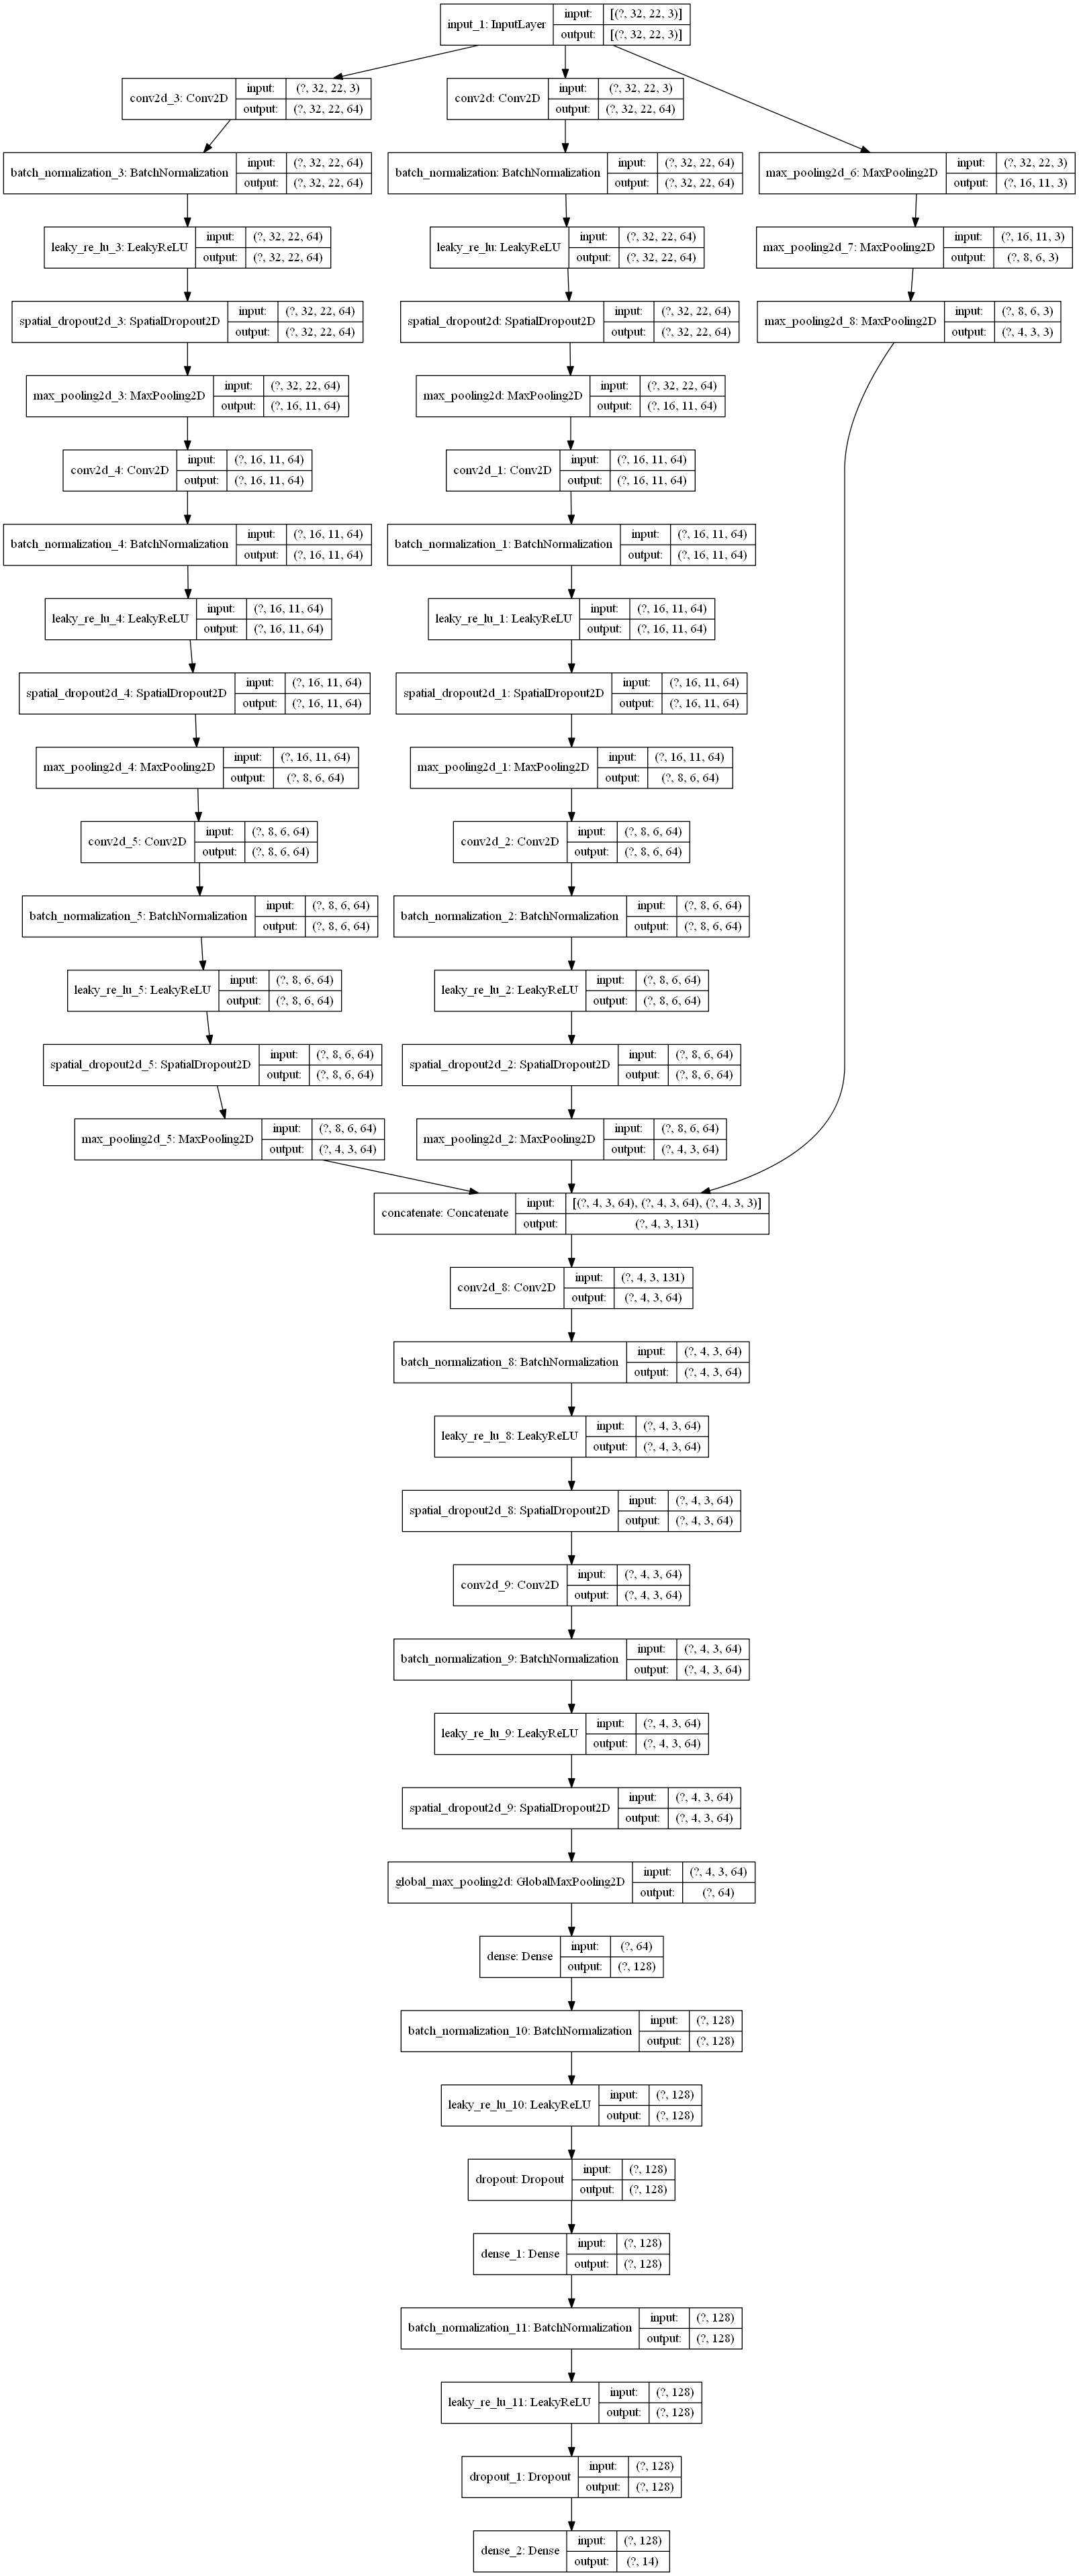

In [9]:
plot_model(model, to_file='model.png', show_shapes=True)

In [10]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

In [11]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

  1%|▊                                                                              | 21/1960 [00:00<00:09, 203.28it/s]C:\Users\Joseph\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|█████████████████████████████████████████████████████████████████████████████| 1960/1960 [00:09<00:00, 206.48it/s]


In [12]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 840/840 [00:04<00:00, 206.14it/s]


In [13]:
"""blank = X_1
blank_test = X_test_1
blank = np.zeros((1960,32,43,3))
blank_test = np.zeros((840,32,43,3))
list = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]
count = 0
for i in range(0,X_1.shape[0]):
    for j in range(0, X_1.shape[1]):
        count = 0
        for k in list:
            blank[i][j][count] = X_1[i][j][k-1]
            count = count + 1
count = 0
for i in range(0, X_test_1.shape[0]):
    for j in range(0, X_test_1.shape[1]):
        count = 0
        for k in list:
            blank_test[i][j][count] = X_test_1[i][j][k-1]
            count = count + 1
X_1 = blank
X_test_1 = blank_test"""

'blank = X_1\nblank_test = X_test_1\nblank = np.zeros((1960,32,43,3))\nblank_test = np.zeros((840,32,43,3))\nlist = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]\ncount = 0\nfor i in range(0,X_1.shape[0]):\n    for j in range(0, X_1.shape[1]):\n        count = 0\n        for k in list:\n            blank[i][j][count] = X_1[i][j][k-1]\n            count = count + 1\ncount = 0\nfor i in range(0, X_test_1.shape[0]):\n    for j in range(0, X_test_1.shape[1]):\n        count = 0\n        for k in list:\n            blank_test[i][j][count] = X_test_1[i][j][k-1]\n            count = count + 1\nX_1 = blank\nX_test_1 = blank_test'

In [14]:
# Training: Optimizer's Learning Rate
learning_rate = 0.001

# We use Adam to optimize a multi-class classification task
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [15]:
# Start the training

# ...with an existing validation set:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=1e-8)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model_Skel2D.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_1, Y, validation_data=(X_test_1, Y_test), epochs=10000, batch_size=32, callbacks=[reduce_lr,es,mc])

# ...or, if there is no validation set:
# history = model.fit(x_train, y_train, validation_split=0.33, epochs=100, batch_size=32)

Train on 1960 samples, validate on 840 samples
Epoch 1/10000
1952/1960 [============================>.] - ETA: 1:36 - loss: 3.0735 - acc: 0.062 - ETA: 50s - loss: 2.9690 - acc: 0.062 - ETA: 35s - loss: 2.8309 - acc: 0.08 - ETA: 27s - loss: 2.7222 - acc: 0.11 - ETA: 22s - loss: 2.6527 - acc: 0.15 - ETA: 19s - loss: 2.5728 - acc: 0.16 - ETA: 17s - loss: 2.5480 - acc: 0.16 - ETA: 15s - loss: 2.4919 - acc: 0.18 - ETA: 14s - loss: 2.4487 - acc: 0.19 - ETA: 12s - loss: 2.4066 - acc: 0.20 - ETA: 11s - loss: 2.3679 - acc: 0.20 - ETA: 11s - loss: 2.3311 - acc: 0.21 - ETA: 10s - loss: 2.2882 - acc: 0.22 - ETA: 9s - loss: 2.2719 - acc: 0.2299 - ETA: 9s - loss: 2.2792 - acc: 0.233 - ETA: 8s - loss: 2.2527 - acc: 0.242 - ETA: 8s - loss: 2.2203 - acc: 0.250 - ETA: 8s - loss: 2.2021 - acc: 0.255 - ETA: 7s - loss: 2.1667 - acc: 0.269 - ETA: 7s - loss: 2.1384 - acc: 0.279 - ETA: 7s - loss: 2.1135 - acc: 0.288 - ETA: 6s - loss: 2.0885 - acc: 0.298 - ETA: 6s - loss: 2.0701 - acc: 0.301 - ETA: 6s - loss: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.3517 - acc: 0.875 - ETA: 6s - loss: 0.4099 - acc: 0.875 - ETA: 5s - loss: 0.3896 - acc: 0.875 - ETA: 5s - loss: 0.3378 - acc: 0.898 - ETA: 5s - loss: 0.3342 - acc: 0.900 - ETA: 5s - loss: 0.3401 - acc: 0.895 - ETA: 5s - loss: 0.3306 - acc: 0.897 - ETA: 5s - loss: 0.3359 - acc: 0.882 - ETA: 5s - loss: 0.3377 - acc: 0.881 - ETA: 5s - loss: 0.3323 - acc: 0.884 - ETA: 5s - loss: 0.3214 - acc: 0.892 - ETA: 5s - loss: 0.3271 - acc: 0.888 - ETA: 4s - loss: 0.3348 - acc: 0.887 - ETA: 4s - loss: 0.3391 - acc: 0.886 - ETA: 4s - loss: 0.3427 - acc: 0.883 - ETA: 4s - loss: 0.3417 - acc: 0.886 - ETA: 4s - loss: 0.3346 - acc: 0.889 - ETA: 4s - loss: 0.3263 - acc: 0.894 - ETA: 4s - loss: 0.3249 - acc: 0.896 - ETA: 4s - loss: 0.3282 - acc: 0.895 - ETA: 4s - loss: 0.3224 - acc: 0.900 - ETA: 4s - loss: 0.3315 - acc: 0.899 - ETA: 3s - loss: 0.3369 - acc: 0.894 - ETA: 3s - loss: 0.3357 - acc: 0.893 - ETA: 3s - loss: 0.3370 - acc: 0.895 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.3189 - acc: 0.875 - ETA: 6s - loss: 0.2477 - acc: 0.906 - ETA: 6s - loss: 0.2619 - acc: 0.906 - ETA: 5s - loss: 0.2291 - acc: 0.921 - ETA: 5s - loss: 0.2670 - acc: 0.906 - ETA: 5s - loss: 0.2545 - acc: 0.911 - ETA: 5s - loss: 0.2751 - acc: 0.892 - ETA: 5s - loss: 0.3177 - acc: 0.886 - ETA: 5s - loss: 0.3044 - acc: 0.895 - ETA: 5s - loss: 0.3149 - acc: 0.900 - ETA: 5s - loss: 0.3358 - acc: 0.894 - ETA: 5s - loss: 0.3318 - acc: 0.893 - ETA: 5s - loss: 0.3294 - acc: 0.896 - ETA: 4s - loss: 0.3428 - acc: 0.890 - ETA: 4s - loss: 0.3342 - acc: 0.893 - ETA: 4s - loss: 0.3346 - acc: 0.888 - ETA: 4s - loss: 0.3276 - acc: 0.889 - ETA: 4s - loss: 0.3205 - acc: 0.894 - ETA: 4s - loss: 0.3142 - acc: 0.898 - ETA: 4s - loss: 0.3242 - acc: 0.895 - ETA: 4s - loss: 0.3235 - acc: 0.895 - ETA: 4s - loss: 0.3180 - acc: 0.897 - ETA: 4s - loss: 0.3150 - acc: 0.898 - ETA: 3s - loss: 0.3079 - acc: 0.899 - ETA: 3s - loss: 0.3097 - acc: 0.898 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.1091 - acc: 0.968 - ETA: 6s - loss: 0.0812 - acc: 0.984 - ETA: 5s - loss: 0.0819 - acc: 0.989 - ETA: 5s - loss: 0.1096 - acc: 0.968 - ETA: 5s - loss: 0.1051 - acc: 0.975 - ETA: 5s - loss: 0.1387 - acc: 0.963 - ETA: 5s - loss: 0.1389 - acc: 0.959 - ETA: 5s - loss: 0.1411 - acc: 0.960 - ETA: 5s - loss: 0.1348 - acc: 0.965 - ETA: 5s - loss: 0.1557 - acc: 0.956 - ETA: 5s - loss: 0.1561 - acc: 0.951 - ETA: 5s - loss: 0.1480 - acc: 0.955 - ETA: 4s - loss: 0.1539 - acc: 0.954 - ETA: 4s - loss: 0.1657 - acc: 0.953 - ETA: 4s - loss: 0.1876 - acc: 0.952 - ETA: 4s - loss: 0.2040 - acc: 0.943 - ETA: 4s - loss: 0.1941 - acc: 0.946 - ETA: 4s - loss: 0.1951 - acc: 0.947 - ETA: 4s - loss: 0.2049 - acc: 0.945 - ETA: 4s - loss: 0.2145 - acc: 0.943 - ETA: 4s - loss: 0.2177 - acc: 0.939 - ETA: 4s - loss: 0.2114 - acc: 0.941 - ETA: 3s - loss: 0.2079 - acc: 0.942 - ETA: 3s - loss: 0.2070 - acc: 0.941 - ETA: 3s - loss: 0.2179 - acc: 0.936 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.2220 - acc: 0.937 - ETA: 5s - loss: 0.1631 - acc: 0.953 - ETA: 6s - loss: 0.1555 - acc: 0.958 - ETA: 5s - loss: 0.1345 - acc: 0.960 - ETA: 5s - loss: 0.1385 - acc: 0.962 - ETA: 5s - loss: 0.1503 - acc: 0.947 - ETA: 5s - loss: 0.1963 - acc: 0.919 - ETA: 5s - loss: 0.1807 - acc: 0.925 - ETA: 5s - loss: 0.1997 - acc: 0.916 - ETA: 5s - loss: 0.2011 - acc: 0.918 - ETA: 5s - loss: 0.1915 - acc: 0.923 - ETA: 5s - loss: 0.1941 - acc: 0.924 - ETA: 4s - loss: 0.2047 - acc: 0.920 - ETA: 4s - loss: 0.1947 - acc: 0.924 - ETA: 4s - loss: 0.2030 - acc: 0.920 - ETA: 4s - loss: 0.1961 - acc: 0.923 - ETA: 4s - loss: 0.1905 - acc: 0.926 - ETA: 4s - loss: 0.2015 - acc: 0.923 - ETA: 4s - loss: 0.1988 - acc: 0.926 - ETA: 4s - loss: 0.1974 - acc: 0.928 - ETA: 4s - loss: 0.1963 - acc: 0.931 - ETA: 4s - loss: 0.1911 - acc: 0.934 - ETA: 3s - loss: 0.1864 - acc: 0.937 - ETA: 3s - loss: 0.1821 - acc: 0.938 - ETA: 3s - loss: 0.1847 - acc: 0.937 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0225 - acc: 1.000 - ETA: 6s - loss: 0.0397 - acc: 1.000 - ETA: 6s - loss: 0.0846 - acc: 0.968 - ETA: 6s - loss: 0.0887 - acc: 0.976 - ETA: 5s - loss: 0.0899 - acc: 0.968 - ETA: 5s - loss: 0.0826 - acc: 0.974 - ETA: 5s - loss: 0.0965 - acc: 0.968 - ETA: 5s - loss: 0.0917 - acc: 0.972 - ETA: 5s - loss: 0.0904 - acc: 0.972 - ETA: 5s - loss: 0.0860 - acc: 0.975 - ETA: 5s - loss: 0.0998 - acc: 0.968 - ETA: 5s - loss: 0.0931 - acc: 0.971 - ETA: 5s - loss: 0.0950 - acc: 0.968 - ETA: 4s - loss: 0.0939 - acc: 0.968 - ETA: 4s - loss: 0.0914 - acc: 0.970 - ETA: 4s - loss: 0.0957 - acc: 0.968 - ETA: 4s - loss: 0.0937 - acc: 0.970 - ETA: 4s - loss: 0.0948 - acc: 0.968 - ETA: 4s - loss: 0.0909 - acc: 0.970 - ETA: 4s - loss: 0.0963 - acc: 0.968 - ETA: 4s - loss: 0.0957 - acc: 0.968 - ETA: 4s - loss: 0.0937 - acc: 0.970 - ETA: 3s - loss: 0.0922 - acc: 0.971 - ETA: 3s - loss: 0.0906 - acc: 0.972 - ETA: 3s - loss: 0.0889 - acc: 0.973 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0686 - acc: 0.968 - ETA: 5s - loss: 0.1490 - acc: 0.953 - ETA: 5s - loss: 0.1427 - acc: 0.958 - ETA: 5s - loss: 0.1255 - acc: 0.960 - ETA: 5s - loss: 0.1153 - acc: 0.962 - ETA: 5s - loss: 0.1168 - acc: 0.963 - ETA: 5s - loss: 0.1253 - acc: 0.964 - ETA: 5s - loss: 0.1259 - acc: 0.964 - ETA: 5s - loss: 0.1198 - acc: 0.965 - ETA: 5s - loss: 0.1113 - acc: 0.968 - ETA: 5s - loss: 0.1127 - acc: 0.965 - ETA: 5s - loss: 0.1103 - acc: 0.966 - ETA: 4s - loss: 0.1163 - acc: 0.963 - ETA: 4s - loss: 0.1152 - acc: 0.964 - ETA: 4s - loss: 0.1099 - acc: 0.966 - ETA: 4s - loss: 0.1082 - acc: 0.964 - ETA: 4s - loss: 0.1053 - acc: 0.966 - ETA: 4s - loss: 0.1022 - acc: 0.968 - ETA: 4s - loss: 0.1037 - acc: 0.967 - ETA: 4s - loss: 0.1019 - acc: 0.968 - ETA: 4s - loss: 0.1029 - acc: 0.968 - ETA: 4s - loss: 0.1016 - acc: 0.968 - ETA: 3s - loss: 0.0995 - acc: 0.970 - ETA: 3s - loss: 0.0962 - acc: 0.971 - ETA: 3s - loss: 0.0957 - acc: 0.972 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0126 - acc: 1.000 - ETA: 6s - loss: 0.0205 - acc: 1.000 - ETA: 6s - loss: 0.1979 - acc: 0.968 - ETA: 6s - loss: 0.1569 - acc: 0.976 - ETA: 5s - loss: 0.1563 - acc: 0.968 - ETA: 5s - loss: 0.1434 - acc: 0.968 - ETA: 5s - loss: 0.1349 - acc: 0.968 - ETA: 5s - loss: 0.1294 - acc: 0.964 - ETA: 5s - loss: 0.1419 - acc: 0.954 - ETA: 5s - loss: 0.1310 - acc: 0.959 - ETA: 5s - loss: 0.1256 - acc: 0.963 - ETA: 5s - loss: 0.1204 - acc: 0.963 - ETA: 4s - loss: 0.1164 - acc: 0.963 - ETA: 4s - loss: 0.1200 - acc: 0.964 - ETA: 4s - loss: 0.1165 - acc: 0.964 - ETA: 4s - loss: 0.1181 - acc: 0.962 - ETA: 4s - loss: 0.1188 - acc: 0.963 - ETA: 4s - loss: 0.1212 - acc: 0.963 - ETA: 4s - loss: 0.1189 - acc: 0.963 - ETA: 4s - loss: 0.1150 - acc: 0.965 - ETA: 4s - loss: 0.1172 - acc: 0.962 - ETA: 4s - loss: 0.1210 - acc: 0.963 - ETA: 3s - loss: 0.1180 - acc: 0.963 - ETA: 3s - loss: 0.1154 - acc: 0.964 - ETA: 3s - loss: 0.1168 - acc: 0.965 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0586 - acc: 1.000 - ETA: 5s - loss: 0.0335 - acc: 1.000 - ETA: 5s - loss: 0.0282 - acc: 1.000 - ETA: 5s - loss: 0.0230 - acc: 1.000 - ETA: 5s - loss: 0.0320 - acc: 0.993 - ETA: 5s - loss: 0.0274 - acc: 0.994 - ETA: 5s - loss: 0.0271 - acc: 0.995 - ETA: 5s - loss: 0.0303 - acc: 0.992 - ETA: 5s - loss: 0.0582 - acc: 0.975 - ETA: 5s - loss: 0.0547 - acc: 0.978 - ETA: 5s - loss: 0.0522 - acc: 0.980 - ETA: 4s - loss: 0.0483 - acc: 0.981 - ETA: 4s - loss: 0.0456 - acc: 0.983 - ETA: 4s - loss: 0.0435 - acc: 0.984 - ETA: 4s - loss: 0.0416 - acc: 0.985 - ETA: 4s - loss: 0.0398 - acc: 0.986 - ETA: 4s - loss: 0.0391 - acc: 0.987 - ETA: 4s - loss: 0.0387 - acc: 0.987 - ETA: 4s - loss: 0.0499 - acc: 0.985 - ETA: 4s - loss: 0.0484 - acc: 0.985 - ETA: 4s - loss: 0.0482 - acc: 0.985 - ETA: 3s - loss: 0.0470 - acc: 0.985 - ETA: 3s - loss: 0.0453 - acc: 0.986 - ETA: 3s - loss: 0.0439 - acc: 0.987 - ETA: 3s - loss: 0.0538 - acc: 0.981 - ETA: 

1952/1960 [============================>.] - ETA: 5s - loss: 0.0175 - acc: 1.000 - ETA: 5s - loss: 0.0286 - acc: 1.000 - ETA: 5s - loss: 0.0274 - acc: 1.000 - ETA: 5s - loss: 0.0262 - acc: 1.000 - ETA: 5s - loss: 0.0222 - acc: 1.000 - ETA: 5s - loss: 0.0210 - acc: 1.000 - ETA: 5s - loss: 0.0240 - acc: 1.000 - ETA: 5s - loss: 0.0241 - acc: 1.000 - ETA: 5s - loss: 0.0256 - acc: 1.000 - ETA: 5s - loss: 0.0351 - acc: 0.996 - ETA: 5s - loss: 0.0526 - acc: 0.991 - ETA: 4s - loss: 0.0550 - acc: 0.989 - ETA: 4s - loss: 0.0588 - acc: 0.988 - ETA: 4s - loss: 0.0569 - acc: 0.988 - ETA: 4s - loss: 0.0536 - acc: 0.989 - ETA: 4s - loss: 0.0542 - acc: 0.988 - ETA: 4s - loss: 0.0533 - acc: 0.989 - ETA: 4s - loss: 0.0519 - acc: 0.989 - ETA: 4s - loss: 0.0512 - acc: 0.988 - ETA: 4s - loss: 0.0509 - acc: 0.987 - ETA: 4s - loss: 0.0534 - acc: 0.985 - ETA: 3s - loss: 0.0512 - acc: 0.985 - ETA: 3s - loss: 0.0493 - acc: 0.986 - ETA: 3s - loss: 0.0477 - acc: 0.987 - ETA: 3s - loss: 0.0503 - acc: 0.985 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0059 - acc: 1.000 - ETA: 5s - loss: 0.0051 - acc: 1.000 - ETA: 5s - loss: 0.0065 - acc: 1.000 - ETA: 5s - loss: 0.0074 - acc: 1.000 - ETA: 5s - loss: 0.0080 - acc: 1.000 - ETA: 5s - loss: 0.0165 - acc: 0.994 - ETA: 5s - loss: 0.0149 - acc: 0.995 - ETA: 5s - loss: 0.0146 - acc: 0.996 - ETA: 5s - loss: 0.0140 - acc: 0.996 - ETA: 5s - loss: 0.0131 - acc: 0.996 - ETA: 4s - loss: 0.0122 - acc: 0.997 - ETA: 4s - loss: 0.0158 - acc: 0.997 - ETA: 4s - loss: 0.0195 - acc: 0.995 - ETA: 4s - loss: 0.0312 - acc: 0.991 - ETA: 4s - loss: 0.0331 - acc: 0.989 - ETA: 4s - loss: 0.0333 - acc: 0.990 - ETA: 4s - loss: 0.0319 - acc: 0.990 - ETA: 4s - loss: 0.0320 - acc: 0.989 - ETA: 4s - loss: 0.0324 - acc: 0.990 - ETA: 4s - loss: 0.0337 - acc: 0.989 - ETA: 3s - loss: 0.0326 - acc: 0.989 - ETA: 3s - loss: 0.0380 - acc: 0.987 - ETA: 3s - loss: 0.0382 - acc: 0.987 - ETA: 3s - loss: 0.0368 - acc: 0.988 - ETA: 3s - loss: 0.0404 - acc: 0.986 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0104 - acc: 1.000 - ETA: 5s - loss: 0.0061 - acc: 1.000 - ETA: 5s - loss: 0.0107 - acc: 1.000 - ETA: 5s - loss: 0.0231 - acc: 0.992 - ETA: 5s - loss: 0.0230 - acc: 0.993 - ETA: 5s - loss: 0.0211 - acc: 0.994 - ETA: 5s - loss: 0.0190 - acc: 0.995 - ETA: 5s - loss: 0.0173 - acc: 0.996 - ETA: 5s - loss: 0.0221 - acc: 0.993 - ETA: 5s - loss: 0.0209 - acc: 0.993 - ETA: 5s - loss: 0.0227 - acc: 0.991 - ETA: 4s - loss: 0.0271 - acc: 0.989 - ETA: 4s - loss: 0.0386 - acc: 0.988 - ETA: 4s - loss: 0.0407 - acc: 0.986 - ETA: 4s - loss: 0.0400 - acc: 0.987 - ETA: 4s - loss: 0.0406 - acc: 0.986 - ETA: 4s - loss: 0.0399 - acc: 0.987 - ETA: 4s - loss: 0.0406 - acc: 0.987 - ETA: 4s - loss: 0.0386 - acc: 0.988 - ETA: 4s - loss: 0.0372 - acc: 0.989 - ETA: 4s - loss: 0.0357 - acc: 0.989 - ETA: 3s - loss: 0.0348 - acc: 0.990 - ETA: 3s - loss: 0.0336 - acc: 0.990 - ETA: 3s - loss: 0.0327 - acc: 0.990 - ETA: 3s - loss: 0.0319 - acc: 0.991 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0182 - acc: 1.000 - ETA: 6s - loss: 0.0553 - acc: 0.984 - ETA: 5s - loss: 0.0385 - acc: 0.989 - ETA: 5s - loss: 0.0322 - acc: 0.992 - ETA: 5s - loss: 0.0396 - acc: 0.987 - ETA: 5s - loss: 0.0341 - acc: 0.989 - ETA: 5s - loss: 0.0304 - acc: 0.991 - ETA: 5s - loss: 0.0304 - acc: 0.992 - ETA: 5s - loss: 0.0280 - acc: 0.993 - ETA: 5s - loss: 0.0307 - acc: 0.990 - ETA: 5s - loss: 0.0307 - acc: 0.991 - ETA: 4s - loss: 0.0307 - acc: 0.992 - ETA: 4s - loss: 0.0291 - acc: 0.992 - ETA: 4s - loss: 0.0286 - acc: 0.993 - ETA: 4s - loss: 0.0271 - acc: 0.993 - ETA: 4s - loss: 0.0260 - acc: 0.994 - ETA: 4s - loss: 0.0255 - acc: 0.994 - ETA: 4s - loss: 0.0278 - acc: 0.993 - ETA: 4s - loss: 0.0334 - acc: 0.991 - ETA: 4s - loss: 0.0336 - acc: 0.992 - ETA: 4s - loss: 0.0332 - acc: 0.992 - ETA: 3s - loss: 0.0323 - acc: 0.992 - ETA: 3s - loss: 0.0314 - acc: 0.993 - ETA: 3s - loss: 0.0311 - acc: 0.993 - ETA: 3s - loss: 0.0304 - acc: 0.993 - ETA: 

1952/1960 [============================>.] - ETA: 5s - loss: 0.0081 - acc: 1.000 - ETA: 5s - loss: 0.0211 - acc: 1.000 - ETA: 5s - loss: 0.0257 - acc: 1.000 - ETA: 5s - loss: 0.0240 - acc: 1.000 - ETA: 5s - loss: 0.0283 - acc: 0.993 - ETA: 5s - loss: 0.0535 - acc: 0.979 - ETA: 5s - loss: 0.0522 - acc: 0.977 - ETA: 5s - loss: 0.0485 - acc: 0.980 - ETA: 5s - loss: 0.0488 - acc: 0.979 - ETA: 5s - loss: 0.0454 - acc: 0.981 - ETA: 5s - loss: 0.0516 - acc: 0.980 - ETA: 5s - loss: 0.0481 - acc: 0.981 - ETA: 4s - loss: 0.0452 - acc: 0.983 - ETA: 4s - loss: 0.0430 - acc: 0.984 - ETA: 4s - loss: 0.0407 - acc: 0.985 - ETA: 4s - loss: 0.0435 - acc: 0.982 - ETA: 4s - loss: 0.0419 - acc: 0.983 - ETA: 4s - loss: 0.0403 - acc: 0.984 - ETA: 4s - loss: 0.0394 - acc: 0.985 - ETA: 4s - loss: 0.0377 - acc: 0.985 - ETA: 4s - loss: 0.0365 - acc: 0.986 - ETA: 3s - loss: 0.0366 - acc: 0.987 - ETA: 3s - loss: 0.0364 - acc: 0.987 - ETA: 3s - loss: 0.0359 - acc: 0.988 - ETA: 3s - loss: 0.0346 - acc: 0.988 - ETA: 

1952/1960 [============================>.] - ETA: 5s - loss: 0.0067 - acc: 1.000 - ETA: 5s - loss: 0.0072 - acc: 1.000 - ETA: 5s - loss: 0.0061 - acc: 1.000 - ETA: 5s - loss: 0.0155 - acc: 1.000 - ETA: 5s - loss: 0.0130 - acc: 1.000 - ETA: 5s - loss: 0.0123 - acc: 1.000 - ETA: 5s - loss: 0.0282 - acc: 0.995 - ETA: 5s - loss: 0.0281 - acc: 0.992 - ETA: 5s - loss: 0.0263 - acc: 0.993 - ETA: 5s - loss: 0.0247 - acc: 0.993 - ETA: 5s - loss: 0.0228 - acc: 0.994 - ETA: 4s - loss: 0.0217 - acc: 0.994 - ETA: 4s - loss: 0.0214 - acc: 0.995 - ETA: 4s - loss: 0.0203 - acc: 0.995 - ETA: 4s - loss: 0.0197 - acc: 0.995 - ETA: 4s - loss: 0.0228 - acc: 0.996 - ETA: 4s - loss: 0.0231 - acc: 0.996 - ETA: 4s - loss: 0.0222 - acc: 0.996 - ETA: 4s - loss: 0.0215 - acc: 0.996 - ETA: 4s - loss: 0.0206 - acc: 0.996 - ETA: 4s - loss: 0.0220 - acc: 0.995 - ETA: 3s - loss: 0.0215 - acc: 0.995 - ETA: 3s - loss: 0.0206 - acc: 0.995 - ETA: 3s - loss: 0.0199 - acc: 0.996 - ETA: 3s - loss: 0.0201 - acc: 0.996 - ETA: 

1952/1960 [============================>.] - ETA: 5s - loss: 0.0083 - acc: 1.000 - ETA: 5s - loss: 0.0102 - acc: 1.000 - ETA: 5s - loss: 0.0093 - acc: 1.000 - ETA: 5s - loss: 0.0076 - acc: 1.000 - ETA: 5s - loss: 0.0071 - acc: 1.000 - ETA: 5s - loss: 0.0065 - acc: 1.000 - ETA: 5s - loss: 0.0072 - acc: 1.000 - ETA: 5s - loss: 0.0079 - acc: 1.000 - ETA: 5s - loss: 0.0091 - acc: 1.000 - ETA: 5s - loss: 0.0135 - acc: 0.996 - ETA: 5s - loss: 0.0159 - acc: 0.994 - ETA: 4s - loss: 0.0157 - acc: 0.994 - ETA: 4s - loss: 0.0147 - acc: 0.995 - ETA: 4s - loss: 0.0161 - acc: 0.993 - ETA: 4s - loss: 0.0177 - acc: 0.993 - ETA: 4s - loss: 0.0170 - acc: 0.994 - ETA: 4s - loss: 0.0175 - acc: 0.994 - ETA: 4s - loss: 0.0173 - acc: 0.994 - ETA: 4s - loss: 0.0168 - acc: 0.995 - ETA: 4s - loss: 0.0162 - acc: 0.995 - ETA: 4s - loss: 0.0156 - acc: 0.995 - ETA: 3s - loss: 0.0161 - acc: 0.995 - ETA: 3s - loss: 0.0160 - acc: 0.995 - ETA: 3s - loss: 0.0155 - acc: 0.996 - ETA: 3s - loss: 0.0154 - acc: 0.996 - ETA: 

1952/1960 [============================>.] - ETA: 5s - loss: 0.0062 - acc: 1.000 - ETA: 5s - loss: 0.0144 - acc: 1.000 - ETA: 5s - loss: 0.0144 - acc: 1.000 - ETA: 5s - loss: 0.0254 - acc: 0.992 - ETA: 5s - loss: 0.0233 - acc: 0.993 - ETA: 5s - loss: 0.0203 - acc: 0.994 - ETA: 5s - loss: 0.0178 - acc: 0.995 - ETA: 5s - loss: 0.0160 - acc: 0.996 - ETA: 5s - loss: 0.0148 - acc: 0.996 - ETA: 5s - loss: 0.0140 - acc: 0.996 - ETA: 5s - loss: 0.0161 - acc: 0.994 - ETA: 5s - loss: 0.0151 - acc: 0.994 - ETA: 4s - loss: 0.0185 - acc: 0.992 - ETA: 4s - loss: 0.0174 - acc: 0.993 - ETA: 4s - loss: 0.0167 - acc: 0.993 - ETA: 4s - loss: 0.0162 - acc: 0.994 - ETA: 4s - loss: 0.0161 - acc: 0.994 - ETA: 4s - loss: 0.0170 - acc: 0.993 - ETA: 4s - loss: 0.0230 - acc: 0.991 - ETA: 4s - loss: 0.0222 - acc: 0.992 - ETA: 4s - loss: 0.0214 - acc: 0.992 - ETA: 3s - loss: 0.0212 - acc: 0.992 - ETA: 3s - loss: 0.0206 - acc: 0.993 - ETA: 3s - loss: 0.0204 - acc: 0.993 - ETA: 3s - loss: 0.0218 - acc: 0.992 - ETA: 

1952/1960 [============================>.] - ETA: 5s - loss: 0.0503 - acc: 0.968 - ETA: 6s - loss: 0.0264 - acc: 0.984 - ETA: 6s - loss: 0.0311 - acc: 0.979 - ETA: 6s - loss: 0.0416 - acc: 0.976 - ETA: 5s - loss: 0.0359 - acc: 0.981 - ETA: 5s - loss: 0.0313 - acc: 0.984 - ETA: 5s - loss: 0.0282 - acc: 0.986 - ETA: 5s - loss: 0.0251 - acc: 0.988 - ETA: 5s - loss: 0.0240 - acc: 0.989 - ETA: 5s - loss: 0.0220 - acc: 0.990 - ETA: 5s - loss: 0.0233 - acc: 0.991 - ETA: 5s - loss: 0.0274 - acc: 0.987 - ETA: 5s - loss: 0.0301 - acc: 0.985 - ETA: 5s - loss: 0.0292 - acc: 0.986 - ETA: 5s - loss: 0.0274 - acc: 0.987 - ETA: 4s - loss: 0.0259 - acc: 0.988 - ETA: 4s - loss: 0.0249 - acc: 0.989 - ETA: 4s - loss: 0.0238 - acc: 0.989 - ETA: 4s - loss: 0.0242 - acc: 0.988 - ETA: 4s - loss: 0.0235 - acc: 0.989 - ETA: 4s - loss: 0.0227 - acc: 0.989 - ETA: 4s - loss: 0.0222 - acc: 0.990 - ETA: 4s - loss: 0.0217 - acc: 0.990 - ETA: 4s - loss: 0.0209 - acc: 0.990 - ETA: 3s - loss: 0.0203 - acc: 0.991 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0287 - acc: 1.000 - ETA: 6s - loss: 0.0291 - acc: 1.000 - ETA: 5s - loss: 0.0213 - acc: 1.000 - ETA: 5s - loss: 0.0249 - acc: 1.000 - ETA: 5s - loss: 0.0203 - acc: 1.000 - ETA: 5s - loss: 0.0175 - acc: 1.000 - ETA: 5s - loss: 0.0194 - acc: 1.000 - ETA: 5s - loss: 0.0178 - acc: 1.000 - ETA: 5s - loss: 0.0169 - acc: 1.000 - ETA: 5s - loss: 0.0154 - acc: 1.000 - ETA: 5s - loss: 0.0153 - acc: 1.000 - ETA: 5s - loss: 0.0183 - acc: 1.000 - ETA: 4s - loss: 0.0171 - acc: 1.000 - ETA: 4s - loss: 0.0179 - acc: 1.000 - ETA: 4s - loss: 0.0177 - acc: 1.000 - ETA: 4s - loss: 0.0169 - acc: 1.000 - ETA: 4s - loss: 0.0164 - acc: 1.000 - ETA: 4s - loss: 0.0160 - acc: 1.000 - ETA: 4s - loss: 0.0201 - acc: 0.998 - ETA: 4s - loss: 0.0207 - acc: 0.998 - ETA: 4s - loss: 0.0198 - acc: 0.998 - ETA: 4s - loss: 0.0199 - acc: 0.998 - ETA: 3s - loss: 0.0194 - acc: 0.998 - ETA: 3s - loss: 0.0202 - acc: 0.997 - ETA: 3s - loss: 0.0200 - acc: 0.997 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0029 - acc: 1.000 - ETA: 6s - loss: 0.0039 - acc: 1.000 - ETA: 6s - loss: 0.0238 - acc: 0.989 - ETA: 6s - loss: 0.0282 - acc: 0.992 - ETA: 6s - loss: 0.0235 - acc: 0.993 - ETA: 6s - loss: 0.0227 - acc: 0.994 - ETA: 6s - loss: 0.0243 - acc: 0.995 - ETA: 5s - loss: 0.0236 - acc: 0.996 - ETA: 5s - loss: 0.0226 - acc: 0.996 - ETA: 5s - loss: 0.0284 - acc: 0.993 - ETA: 5s - loss: 0.0275 - acc: 0.994 - ETA: 5s - loss: 0.0258 - acc: 0.994 - ETA: 5s - loss: 0.0279 - acc: 0.992 - ETA: 5s - loss: 0.0260 - acc: 0.993 - ETA: 5s - loss: 0.0248 - acc: 0.993 - ETA: 5s - loss: 0.0244 - acc: 0.994 - ETA: 4s - loss: 0.0234 - acc: 0.994 - ETA: 4s - loss: 0.0228 - acc: 0.994 - ETA: 4s - loss: 0.0239 - acc: 0.995 - ETA: 4s - loss: 0.0239 - acc: 0.995 - ETA: 4s - loss: 0.0322 - acc: 0.991 - ETA: 4s - loss: 0.0310 - acc: 0.991 - ETA: 4s - loss: 0.0309 - acc: 0.991 - ETA: 4s - loss: 0.0316 - acc: 0.990 - ETA: 3s - loss: 0.0305 - acc: 0.991 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0019 - acc: 1.000 - ETA: 6s - loss: 0.0063 - acc: 1.000 - ETA: 6s - loss: 0.0106 - acc: 1.000 - ETA: 5s - loss: 0.0124 - acc: 1.000 - ETA: 5s - loss: 0.0114 - acc: 1.000 - ETA: 5s - loss: 0.0104 - acc: 1.000 - ETA: 5s - loss: 0.0097 - acc: 1.000 - ETA: 5s - loss: 0.0091 - acc: 1.000 - ETA: 5s - loss: 0.0086 - acc: 1.000 - ETA: 5s - loss: 0.0206 - acc: 0.990 - ETA: 5s - loss: 0.0196 - acc: 0.991 - ETA: 5s - loss: 0.0187 - acc: 0.992 - ETA: 5s - loss: 0.0174 - acc: 0.992 - ETA: 4s - loss: 0.0177 - acc: 0.993 - ETA: 4s - loss: 0.0168 - acc: 0.993 - ETA: 4s - loss: 0.0167 - acc: 0.994 - ETA: 4s - loss: 0.0162 - acc: 0.994 - ETA: 4s - loss: 0.0156 - acc: 0.994 - ETA: 4s - loss: 0.0154 - acc: 0.995 - ETA: 4s - loss: 0.0157 - acc: 0.995 - ETA: 4s - loss: 0.0159 - acc: 0.995 - ETA: 4s - loss: 0.0155 - acc: 0.995 - ETA: 4s - loss: 0.0198 - acc: 0.994 - ETA: 3s - loss: 0.0191 - acc: 0.994 - ETA: 3s - loss: 0.0195 - acc: 0.995 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0305 - acc: 1.000 - ETA: 6s - loss: 0.0268 - acc: 1.000 - ETA: 6s - loss: 0.0295 - acc: 1.000 - ETA: 6s - loss: 0.0235 - acc: 1.000 - ETA: 6s - loss: 0.0214 - acc: 1.000 - ETA: 6s - loss: 0.0212 - acc: 1.000 - ETA: 5s - loss: 0.0206 - acc: 1.000 - ETA: 5s - loss: 0.0207 - acc: 1.000 - ETA: 5s - loss: 0.0189 - acc: 1.000 - ETA: 5s - loss: 0.0196 - acc: 1.000 - ETA: 5s - loss: 0.0182 - acc: 1.000 - ETA: 5s - loss: 0.0200 - acc: 1.000 - ETA: 5s - loss: 0.0193 - acc: 1.000 - ETA: 5s - loss: 0.0182 - acc: 1.000 - ETA: 5s - loss: 0.0180 - acc: 1.000 - ETA: 5s - loss: 0.0172 - acc: 1.000 - ETA: 4s - loss: 0.0165 - acc: 1.000 - ETA: 4s - loss: 0.0160 - acc: 1.000 - ETA: 4s - loss: 0.0154 - acc: 1.000 - ETA: 4s - loss: 0.0150 - acc: 1.000 - ETA: 4s - loss: 0.0144 - acc: 1.000 - ETA: 4s - loss: 0.0140 - acc: 1.000 - ETA: 4s - loss: 0.0136 - acc: 1.000 - ETA: 4s - loss: 0.0153 - acc: 0.998 - ETA: 4s - loss: 0.0155 - acc: 0.998 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0195 - acc: 1.000 - ETA: 6s - loss: 0.0105 - acc: 1.000 - ETA: 6s - loss: 0.0087 - acc: 1.000 - ETA: 5s - loss: 0.0337 - acc: 0.992 - ETA: 5s - loss: 0.0299 - acc: 0.993 - ETA: 5s - loss: 0.0360 - acc: 0.989 - ETA: 5s - loss: 0.0319 - acc: 0.991 - ETA: 5s - loss: 0.0350 - acc: 0.988 - ETA: 5s - loss: 0.0352 - acc: 0.986 - ETA: 5s - loss: 0.0396 - acc: 0.984 - ETA: 5s - loss: 0.0368 - acc: 0.985 - ETA: 5s - loss: 0.0343 - acc: 0.987 - ETA: 5s - loss: 0.0320 - acc: 0.988 - ETA: 4s - loss: 0.0308 - acc: 0.988 - ETA: 4s - loss: 0.0294 - acc: 0.989 - ETA: 4s - loss: 0.0282 - acc: 0.990 - ETA: 4s - loss: 0.0267 - acc: 0.990 - ETA: 4s - loss: 0.0275 - acc: 0.991 - ETA: 4s - loss: 0.0265 - acc: 0.991 - ETA: 4s - loss: 0.0253 - acc: 0.992 - ETA: 4s - loss: 0.0271 - acc: 0.991 - ETA: 4s - loss: 0.0261 - acc: 0.991 - ETA: 4s - loss: 0.0310 - acc: 0.989 - ETA: 3s - loss: 0.0299 - acc: 0.989 - ETA: 3s - loss: 0.0292 - acc: 0.990 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0475 - acc: 0.968 - ETA: 5s - loss: 0.0251 - acc: 0.984 - ETA: 5s - loss: 0.0242 - acc: 0.989 - ETA: 5s - loss: 0.0245 - acc: 0.992 - ETA: 5s - loss: 0.0214 - acc: 0.993 - ETA: 5s - loss: 0.0182 - acc: 0.994 - ETA: 5s - loss: 0.0195 - acc: 0.991 - ETA: 5s - loss: 0.0197 - acc: 0.992 - ETA: 5s - loss: 0.0191 - acc: 0.993 - ETA: 5s - loss: 0.0182 - acc: 0.993 - ETA: 5s - loss: 0.0181 - acc: 0.994 - ETA: 5s - loss: 0.0183 - acc: 0.994 - ETA: 5s - loss: 0.0181 - acc: 0.995 - ETA: 4s - loss: 0.0175 - acc: 0.995 - ETA: 4s - loss: 0.0166 - acc: 0.995 - ETA: 4s - loss: 0.0173 - acc: 0.996 - ETA: 4s - loss: 0.0167 - acc: 0.996 - ETA: 4s - loss: 0.0163 - acc: 0.996 - ETA: 4s - loss: 0.0160 - acc: 0.996 - ETA: 4s - loss: 0.0156 - acc: 0.996 - ETA: 4s - loss: 0.0152 - acc: 0.997 - ETA: 4s - loss: 0.0148 - acc: 0.997 - ETA: 3s - loss: 0.0145 - acc: 0.997 - ETA: 3s - loss: 0.0143 - acc: 0.997 - ETA: 3s - loss: 0.0145 - acc: 0.997 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0084 - acc: 1.000 - ETA: 6s - loss: 0.0099 - acc: 1.000 - ETA: 6s - loss: 0.0077 - acc: 1.000 - ETA: 6s - loss: 0.0121 - acc: 1.000 - ETA: 6s - loss: 0.0117 - acc: 1.000 - ETA: 6s - loss: 0.0120 - acc: 1.000 - ETA: 5s - loss: 0.0117 - acc: 1.000 - ETA: 5s - loss: 0.0143 - acc: 0.996 - ETA: 5s - loss: 0.0136 - acc: 0.996 - ETA: 5s - loss: 0.0134 - acc: 0.996 - ETA: 5s - loss: 0.0142 - acc: 0.997 - ETA: 5s - loss: 0.0134 - acc: 0.997 - ETA: 5s - loss: 0.0127 - acc: 0.997 - ETA: 5s - loss: 0.0121 - acc: 0.997 - ETA: 5s - loss: 0.0118 - acc: 0.997 - ETA: 4s - loss: 0.0113 - acc: 0.998 - ETA: 4s - loss: 0.0111 - acc: 0.998 - ETA: 4s - loss: 0.0111 - acc: 0.998 - ETA: 4s - loss: 0.0106 - acc: 0.998 - ETA: 4s - loss: 0.0103 - acc: 0.998 - ETA: 4s - loss: 0.0103 - acc: 0.998 - ETA: 4s - loss: 0.0109 - acc: 0.998 - ETA: 4s - loss: 0.0109 - acc: 0.998 - ETA: 4s - loss: 0.0123 - acc: 0.997 - ETA: 3s - loss: 0.0119 - acc: 0.997 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0320 - acc: 0.968 - ETA: 6s - loss: 0.0267 - acc: 0.984 - ETA: 6s - loss: 0.0359 - acc: 0.979 - ETA: 5s - loss: 0.0282 - acc: 0.984 - ETA: 5s - loss: 0.0249 - acc: 0.987 - ETA: 5s - loss: 0.0235 - acc: 0.989 - ETA: 5s - loss: 0.0372 - acc: 0.986 - ETA: 5s - loss: 0.0335 - acc: 0.988 - ETA: 5s - loss: 0.0310 - acc: 0.989 - ETA: 5s - loss: 0.0289 - acc: 0.990 - ETA: 5s - loss: 0.0282 - acc: 0.991 - ETA: 5s - loss: 0.0262 - acc: 0.992 - ETA: 5s - loss: 0.0287 - acc: 0.990 - ETA: 5s - loss: 0.0298 - acc: 0.988 - ETA: 4s - loss: 0.0284 - acc: 0.989 - ETA: 4s - loss: 0.0269 - acc: 0.990 - ETA: 4s - loss: 0.0302 - acc: 0.989 - ETA: 4s - loss: 0.0288 - acc: 0.989 - ETA: 4s - loss: 0.0276 - acc: 0.990 - ETA: 4s - loss: 0.0269 - acc: 0.990 - ETA: 4s - loss: 0.0269 - acc: 0.989 - ETA: 4s - loss: 0.0267 - acc: 0.990 - ETA: 4s - loss: 0.0257 - acc: 0.990 - ETA: 4s - loss: 0.0268 - acc: 0.989 - ETA: 3s - loss: 0.0285 - acc: 0.988 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0039 - acc: 1.000 - ETA: 6s - loss: 0.0036 - acc: 1.000 - ETA: 5s - loss: 0.0066 - acc: 1.000 - ETA: 5s - loss: 0.0064 - acc: 1.000 - ETA: 5s - loss: 0.0056 - acc: 1.000 - ETA: 5s - loss: 0.0051 - acc: 1.000 - ETA: 5s - loss: 0.0057 - acc: 1.000 - ETA: 5s - loss: 0.0064 - acc: 1.000 - ETA: 5s - loss: 0.0083 - acc: 1.000 - ETA: 5s - loss: 0.0078 - acc: 1.000 - ETA: 5s - loss: 0.0073 - acc: 1.000 - ETA: 5s - loss: 0.0070 - acc: 1.000 - ETA: 5s - loss: 0.0073 - acc: 1.000 - ETA: 4s - loss: 0.0070 - acc: 1.000 - ETA: 4s - loss: 0.0067 - acc: 1.000 - ETA: 4s - loss: 0.0065 - acc: 1.000 - ETA: 4s - loss: 0.0114 - acc: 0.998 - ETA: 4s - loss: 0.0134 - acc: 0.996 - ETA: 4s - loss: 0.0130 - acc: 0.996 - ETA: 4s - loss: 0.0146 - acc: 0.995 - ETA: 4s - loss: 0.0149 - acc: 0.995 - ETA: 4s - loss: 0.0144 - acc: 0.995 - ETA: 3s - loss: 0.0146 - acc: 0.995 - ETA: 3s - loss: 0.0142 - acc: 0.996 - ETA: 3s - loss: 0.0138 - acc: 0.996 - ETA: 

In [16]:
print(max(history.history['val_acc']))

0.9559524


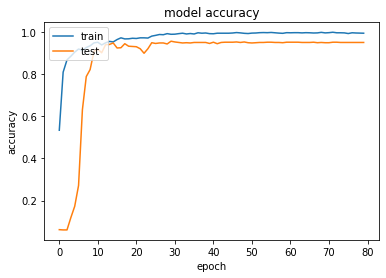

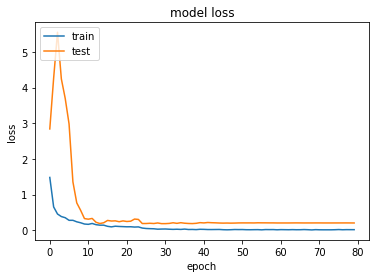

In [17]:
# plot everything
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
model = tf.keras.models.load_model('best_model_Skel2D.h5')
_, train_accuracy = model.evaluate(X_1, Y)
_, test_accuracy = model.evaluate(X_test_1, Y_test)

1960/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 1s 568us/sample - loss: 0.0029 - acc: 0.9980


840/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [19]:
print('Accuracy on train set: {:.2f}%'.format(100 * train_accuracy))
print('Accuracy on test set: {:.2f}%'.format(100 * test_accuracy))

Accuracy on train set: 99.80%
Accuracy on test set: 95.60%


In [20]:
Y_pred = model.predict(X_test_1)
labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

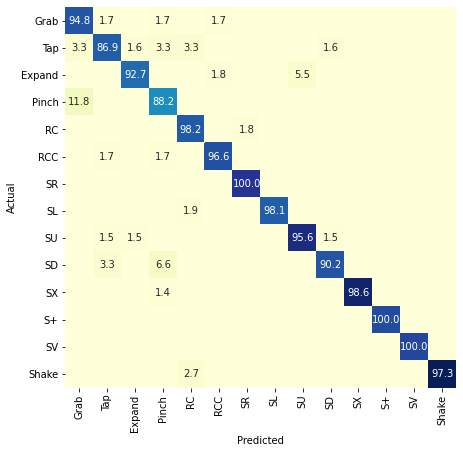

In [21]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_14.png', labels, ymap=None, figsize=(7,7))

In [22]:
Y_pred = model.predict(X_test_1)
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

E:\Skelnet2D\SHREC\utils.py:83: RuntimeWarning: invalid value encountered in true_divide
  cm_perc = cm / cm_sum.astype(float) * 100


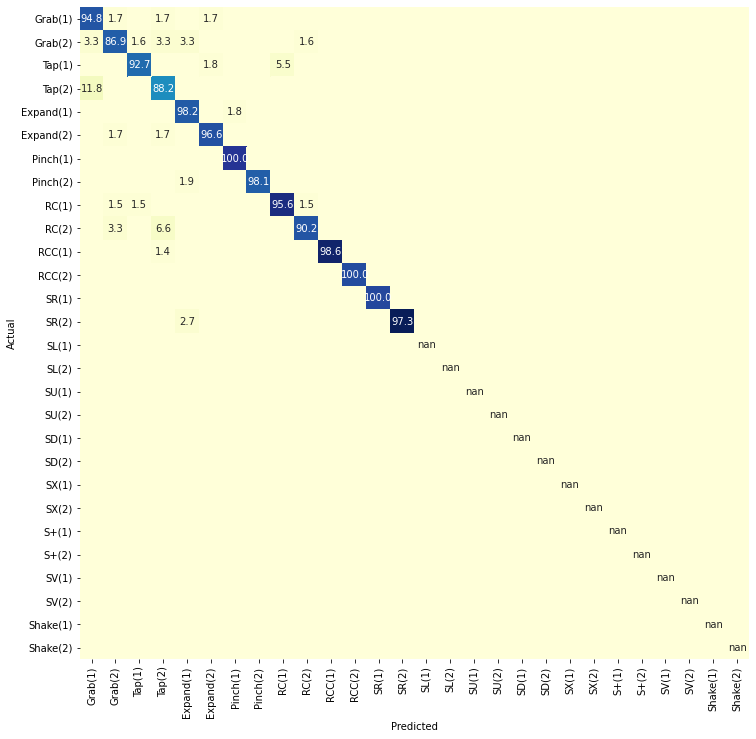

In [23]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_28.png', labels, ymap=None, figsize=(12,12))